We are looking at the data set for WiFi usage in the City of Chicago libraries.
In general, we would expect an upwards trend in WiFi usage due to the increasing availability and awareness of WiFi resources.
However, it would be interesting to see if there are seasonal ups and downs, because of the Chicago winter.
It would also help to justify such programs in the future, as politicians are wont to cut funding to public programs.

First using the constructor in time_series.py, we import the "Libraries_WiFi.csv" file from the data folder.
This file contains WiFi usage statistics for the city of Chicago libraries from 2011 to 2014, by month.
This set came from Canvas, but originally from the City of Chicago data page.

We then clean up the inputs using a special function to append a column of Python datetime objects to our NumPy array, so that we can better handle date/time sorting and printing.

In [2]:
# import the "Libraries_WiFi.csv" file
import time_series as ts
import matplotlib.pyplot as plt
import numpy as np
wifi = ts.TimeSeries("data/Libraries_WiFi.csv")
# clean it up
wifi.cleanup_wifi()
print(wifi.data)

[['DATE_TIME' 'MONTH' 'YEAR' 'NUMBER OF SESSIONS'
  'CUMULATIVE NUMBER OF SESSIONS']
 [datetime.datetime(2011, 1, 1, 0, 0) 'January' '2011' '22263' '22263']
 [datetime.datetime(2011, 2, 1, 0, 0) 'February' '2011' '19657' '41920']
 [datetime.datetime(2011, 3, 1, 0, 0) 'March' '2011' '24506' '66426']
 [datetime.datetime(2011, 4, 1, 0, 0) 'April' '2011' '23998' '90424']
 [datetime.datetime(2011, 5, 1, 0, 0) 'May' '2011' '23242' '113666']
 [datetime.datetime(2011, 6, 1, 0, 0) 'June' '2011' '26044' '139710']
 [datetime.datetime(2011, 7, 1, 0, 0) 'July' '2011' '27735' '167445']
 [datetime.datetime(2011, 8, 1, 0, 0) 'August' '2011' '33934' '201379']
 [datetime.datetime(2011, 9, 1, 0, 0) 'September' '2011' '32714' '234093']
 [datetime.datetime(2011, 10, 1, 0, 0) 'October' '2011' '34760' '268853']
 [datetime.datetime(2011, 11, 1, 0, 0) 'November' '2011' '33535' '302388']
 [datetime.datetime(2011, 12, 1, 0, 0) 'December' '2011' '31842' '334230']
 [datetime.datetime(2012, 1, 1, 0, 0) 'January' '2

We now plot the month/year on the X axis and the number of WiFi sessions on the Y axis.

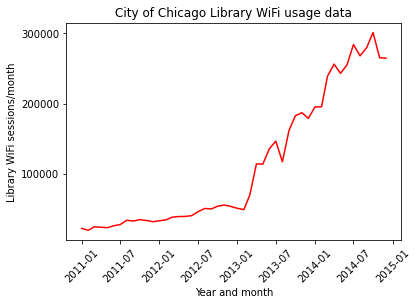

In [3]:
# call the plot
dates = []
for date in wifi.data[1:,0]:
    dates.append(date)
numbers = []
for point in wifi.data[1:,3].astype(int):
    numbers.append(point)
wifi.graph(dates, numbers)
plt.locator_params(axis='y', nbins=6)
plt.xticks(rotation=45)
plt.ticklabel_format(axis='y', style="plain")
plt.title("City of Chicago Library WiFi usage data")
plt.xlabel("Year and month")
plt.ylabel("Library WiFi sessions/month")
wifi.show_graph()

We would now like the calculate the moving average of our data. For our purposes, we'll do a 3-month moving average.

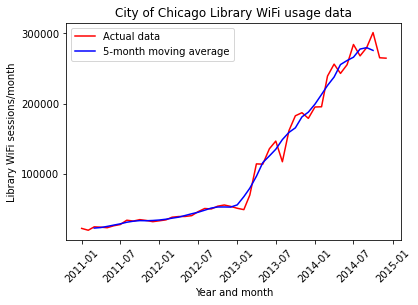

In [4]:
wifi.close_graph()

# define the window
window = 5
usage = wifi.data[1:,3].astype(int)
filtered = []
for point in usage:
    filtered.append(point)
data = wifi.moving_average(filtered, window)
movingAverage = data[0]
window = data[1]
dates = wifi.data[(1 + window // 2):(len(usage) - (window // 2) + 1), 0]

wifi.graph(wifi.data[1:,0], filtered)
wifi.graph(dates, movingAverage, 'b')
plt.locator_params(axis='y', nbins=6)
plt.xticks(rotation=45)
plt.ticklabel_format(axis='y', style="plain")
plt.title("City of Chicago Library WiFi usage data")
plt.xlabel("Year and month")
plt.ylabel("Library WiFi sessions/month")
plt.gca().legend(("Actual data", (str(window) + "-month moving average")))  
wifi.show_graph()

We now use linear regression on the moving average to determine what kind, if any, relationship exists between months and library usage.

We define the first month in our data set as month 1. Accordingly, the last month is thus month 48.

In [5]:
# our simple moving average 
times = list(range((1 + window // 2), (len(usage) - (window // 2) + 1)))
# calculate y = ax + b
a = np.vstack([np.array(times), np.ones(len(times))]).T
# force zero intercept
b = np.vstack([np.array(times), np.zeros(len(times))]).T
m, c = wifi.least_squares(a, np.array(movingAverage))
p, q = wifi.least_squares(b, np.array(movingAverage))
print("Zero intercept (y=ax): a=" + str(p))
print("With intercept (y=ax+b): a=" + str(m) + " and b=" + str(c))

Zero intercept (y=ax): a=4911.804840924012
With intercept (y=ax+b): a=6514.598703312192 and b=-49817.45004933061


We now need to find the residuals for each, in order to determine which is the better model. We can plot them out:

Residuals with intercept: 42756319845.77353


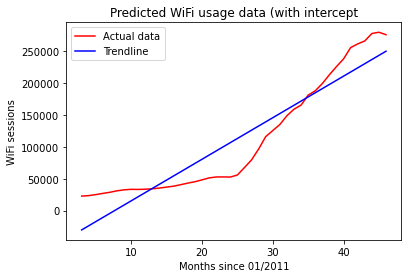

Residuals without intercept: 65879389113.29479


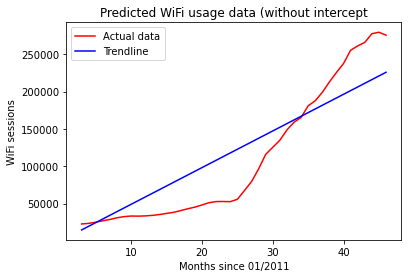

In [12]:
resid_with_intercept = wifi.residuals(times, movingAverage, m, c)
print("Residuals with intercept: " + str(resid_with_intercept))
wifi.graph(times, movingAverage)
trendline = []
for value in times:
    trendline.append(m * value + c)
plt.plot(times, trendline, 'b')
plt.title("Predicted WiFi usage data (with intercept")
plt.xlabel("Months since 01/2011")
plt.ylabel("WiFi sessions")
plt.gca().legend(("Actual data", "Trendline"))
wifi.show_graph()
wifi.close_graph()
resid_without_intercept = wifi.residuals(times, movingAverage, p, q)
print("Residuals without intercept: " + str(resid_without_intercept))
wifi.graph(times, movingAverage)
trendline = []
for value in times:
    trendline.append(p * value + q)
plt.plot(times, trendline, 'b')
plt.title("Predicted WiFi usage data (without intercept")
plt.xlabel("Months since 01/2011")
plt.ylabel("WiFi sessions")
plt.gca().legend(("Actual data", "Trendline"))
wifi.show_graph()
wifi.close_graph()

As can be seen, both residuals are very, very large, because the data is not very linear at all. However, the residual data for the equation with intercept is quite a bit smaller, so it is the preferable model.

Regardless of model, both drastically undercount the future number of library WiFi users, because the count does not grow linearly, but rather somewhat more exponentially. Thus, the best approach would be to not use a linear model at all.